Засоби підготовки та аналізу даних

Лабораторна робота №7 Сценарії обробки багатоспектральних супутникових зображень

Мета роботи: ознайомитися з основними принципами обробки даних дистанційного зондування Землі (ДЗЗ) та можливостями мови Python для обробки геопросторової інформації, а саме, багатоспектральних супутникових зображень засобами бібліотеки абстракції супутникової інформації (GDAL).

In [30]:
import os
import zipfile
import shutil
import sys
import subprocess
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

КРОК 1: Розпаковка архівів Sentinel-2

In [31]:
archives = [
    "lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip",
    "lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip"
]

def extract(archives):
    for archive_path in archives:
        extract_dir = os.path.splitext(archive_path)[0]  # без .zip
        if os.path.exists(extract_dir):
            shutil.rmtree(extract_dir)
            print(f"Видалено наявний каталог: {extract_dir}")
        os.makedirs(extract_dir, exist_ok=True)
        print(f"Створено новий каталог: {extract_dir}")
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Розпаковано: {archive_path}")

extract(archives)
print("Усі архіви успішно розпаковано.\n")

Видалено наявний каталог: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Створено новий каталог: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Розпаковано: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip
Видалено наявний каталог: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Створено новий каталог: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Розпаковано: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip
Усі архіви успішно розпаковано.



КРОК 2: Конкатенація каналів

Конкатенація завершена: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\merged.tif


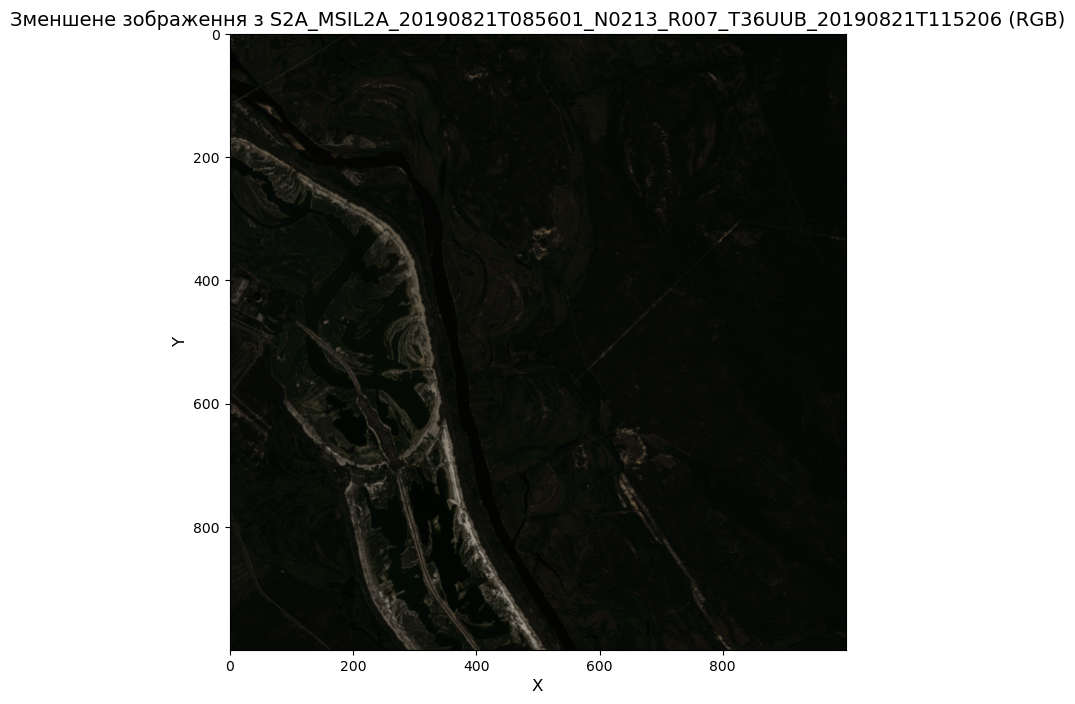

Конкатенація завершена: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\merged.tif


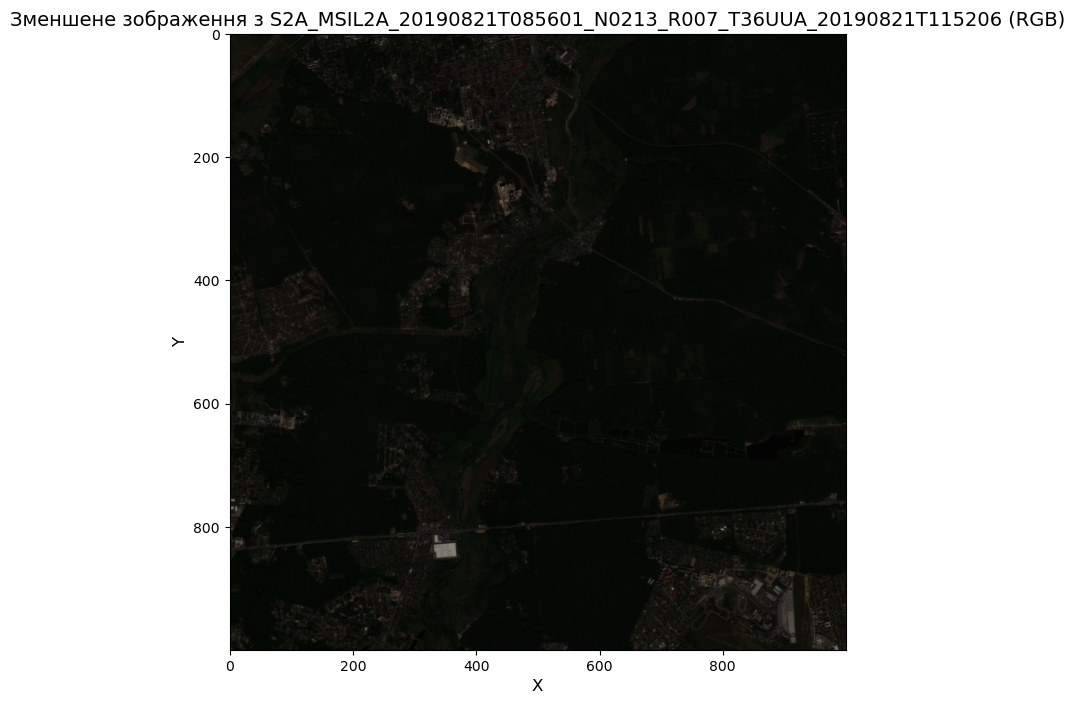

In [32]:
# cписок розпакованих директорій (без .zip)
granules = [os.path.splitext(p)[0] for p in archives]

# канали, які нас цікавлять
bands = ["B02", "B03", "B04", "B08"]

for granule in granules:
    jp2_dir = None

    # пошук папки R10m
    for root, dirs, files in os.walk(granule):
        if "R10m" in root:
            jp2_dir = root
            break

    if not jp2_dir:
        print(f"Не знайдено папку R10m в {granule}")
        continue

    # повні шляхи до каналів
    band_paths = []
    for band in bands:
        matched = [f for f in os.listdir(jp2_dir) if band in f and f.endswith(".jp2")]
        if matched:
            band_paths.append(os.path.join(jp2_dir, matched[0]))
        else:
            print(f"Не знайдено канал {band} у {jp2_dir}")

    if len(band_paths) != 4:
        print(f"Не всі канали знайдено для {granule}. Пропуск.")
        continue

    # output
    output_tif = os.path.join(granule, "merged.tif")

    # шлях до gdal_merge.py
    gdal_merge = os.path.join(sys.prefix, "Scripts", "gdal_merge.py")

    # команда об'єднання
    cmd = ["python", gdal_merge, "-separate", "-o", output_tif] + band_paths
    subprocess.run(cmd)
    print(f"Конкатенація завершена: {output_tif}")

    # вивід RGB-зображення (B04, B03, B02)
    #try:
    #    with rasterio.open(output_tif) as src:
    #       rgb = src.read([3, 2, 1])  # B04, B03, B02
    #       rgb_cropped = rgb[:, :1000, :1000]  # Відрізати частину
    #
    #        rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)
    #
    #       plt.figure(figsize=(8, 8))
    #       plt.imshow(rgb_norm)
    #       plt.title(f"Зменшене зображення з {os.path.basename(granule)} (RGB)")
    #       plt.axis("off")
    #       plt.show()

    #except Exception as e:
    #    print(f"Не вдалося відкрити {output_tif}: {e}")

    try:
        with rasterio.open(output_tif) as src:
            rgb = src.read([3, 2, 1])  # B04, B03, B02
            rgb_cropped = rgb[:, :1000, :1000]  # відрізати частину, якщо дуже велике

            rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)

            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_norm)

            plt.title(f"Зменшене зображення з {os.path.basename(granule)} (RGB)", fontsize=14)
            plt.xlabel("X", fontsize=12)
            plt.ylabel("Y", fontsize=12)
            plt.show()
    
    except Exception as e:
            print(f"Не вдалося відкрити {output_tif}: {e}")

Перепроектовано: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\reprojected.tif


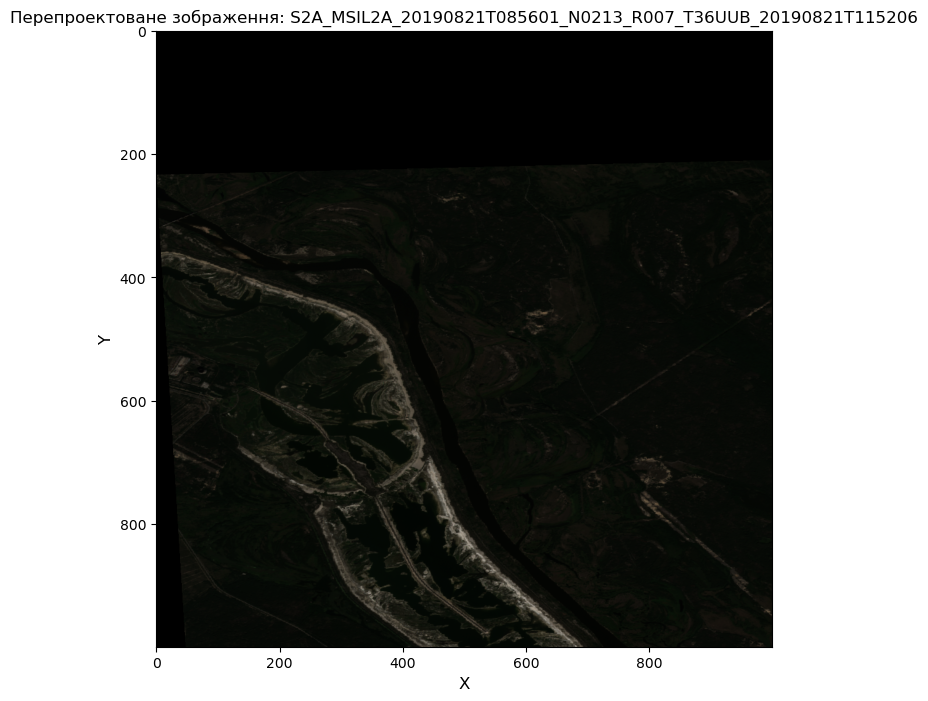

Перепроектовано: lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\reprojected.tif


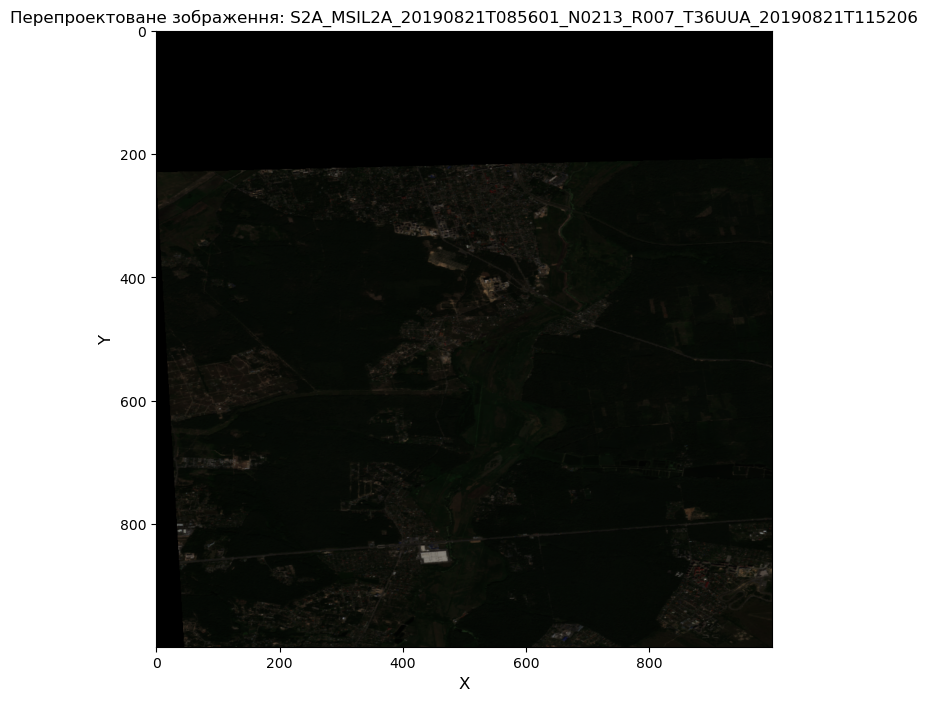

In [33]:
# гранули 
granules = [
    "lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "lab71/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
]

# перепроєктування merged.tif у EPSG:4326
reprojected_files = []

for granule in granules:
    input_file = os.path.join(granule, "merged.tif")
    output_file = os.path.join(granule, "reprojected.tif")

    cmd = [
        "gdalwarp",
        "-s_srs", "EPSG:32636",  # початкова проекція (UTM Zone 36N)
        "-t_srs", "EPSG:4326",   # фінальна (WGS84)
        input_file,
        output_file
    ]
    subprocess.run(cmd)
    print(f"Перепроектовано: {output_file}")
    reprojected_files.append(output_file)

    try:
        with rasterio.open(output_file) as src:
            rgb = src.read([3, 2, 1])
            rgb_cropped = rgb[:, :1000, :1000]
            rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)

            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_norm)
            plt.title(f"Перепроектоване зображення: {os.path.basename(granule)}")
            # plt.axis("off")
            plt.xlabel("X", fontsize=12)
            plt.ylabel("Y", fontsize=12)
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {output_file}: {e}")

Конкатенація завершена: lab71/result/final_merged_4bands.tif


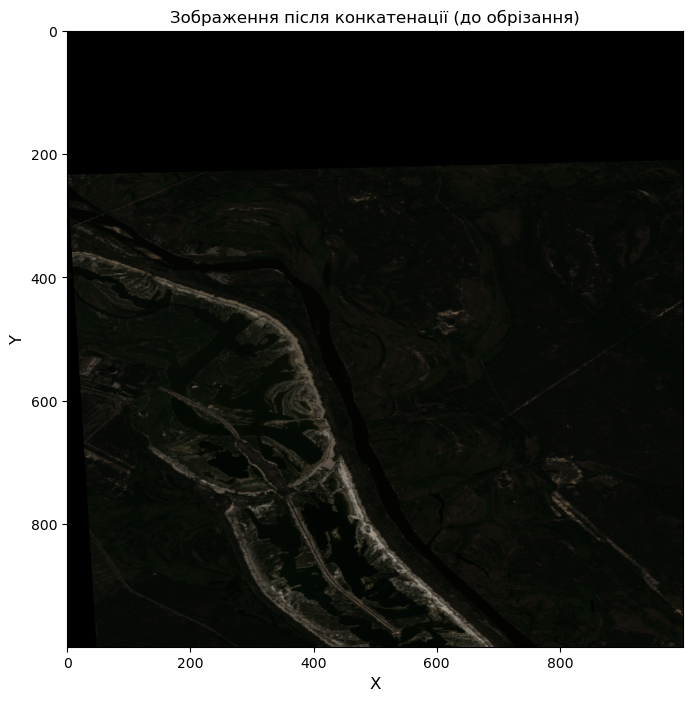

In [34]:
# конкатенація у 4-канальний TIFF
os.makedirs("lab71/result", exist_ok=True)
merged_output = "lab71/result/final_merged_4bands.tif"

gdal_merge = os.path.join(sys.prefix, "Scripts", "gdal_merge.py")
merge_cmd = ["python", gdal_merge, "-separate", "-o", merged_output] + reprojected_files
subprocess.run(merge_cmd)
print(f"Конкатенація завершена: {merged_output}")

# візуалізація 4-канального результату до обрізання
try:
    with rasterio.open(merged_output) as src:
        rgb = src.read([3, 2, 1])  # Red = 3, Green = 2, Blue = 1
        rgb_cropped = rgb[:, :1000, :1000]  # опціонально обрізати фрагмент

        rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)

        plt.figure(figsize=(8, 8))
        plt.imshow(rgb_norm)
        plt.title("Зображення після конкатенації (до обрізання)")
        plt.xlabel("X", fontsize=12)
        plt.ylabel("Y", fontsize=12)
        plt.show()

except Exception as e:
    print(f"Не вдалося відкрити {merged_output}: {e}")

Обрізано по шейпу: lab71/result/final_clipped.tif


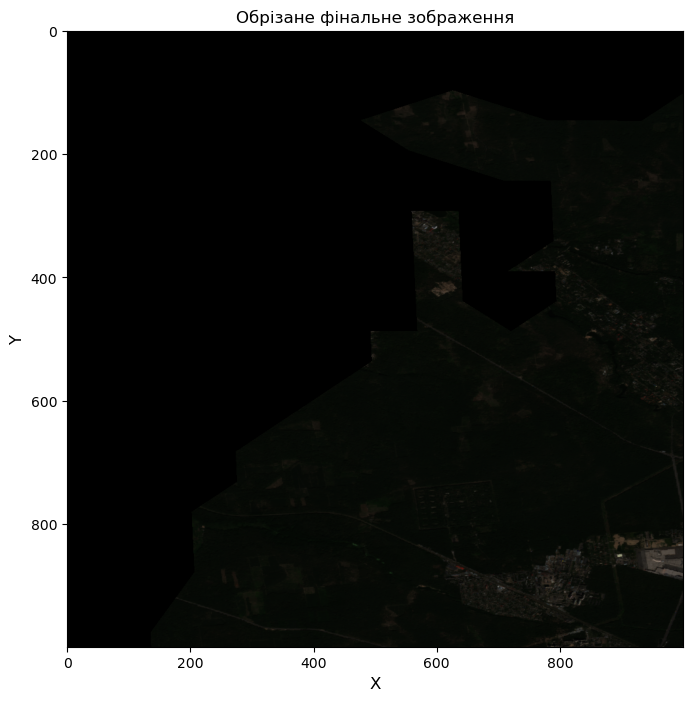

In [35]:
# обрізання по шейпу
shapefile = "lab71/kyiv_regions.shp"
clipped_output = "lab71/result/final_clipped.tif"

cut_cmd = [
    "gdalwarp",
    "-cutline", shapefile,
    "-crop_to_cutline",
    "-dstnodata", "0",
    merged_output,
    clipped_output
]
subprocess.run(cut_cmd)
print(f"Обрізано по шейпу: {clipped_output}")

try:
    with rasterio.open(clipped_output) as src:
        rgb = src.read([3, 2, 1])
        rgb_cropped = rgb[:, :1000, :1000]
        rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)

        plt.figure(figsize=(8, 8))
        plt.imshow(rgb_norm)
        plt.title("Обрізане фінальне зображення")
        plt.xlabel("X", fontsize=12)
        plt.ylabel("Y", fontsize=12)
        plt.show()
except Exception as e:
    print(f"Не вдалося відкрити {clipped_output}: {e}")


Шейп-файл знайдено
CRS шейп-файлу: EPSG:4326
STDOUT:
 
STDERR:
 ERROR 1: Output dataset lab71/result/final_clipped.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.


Обрізане зображення створено: lab71/result/final_clipped.tif


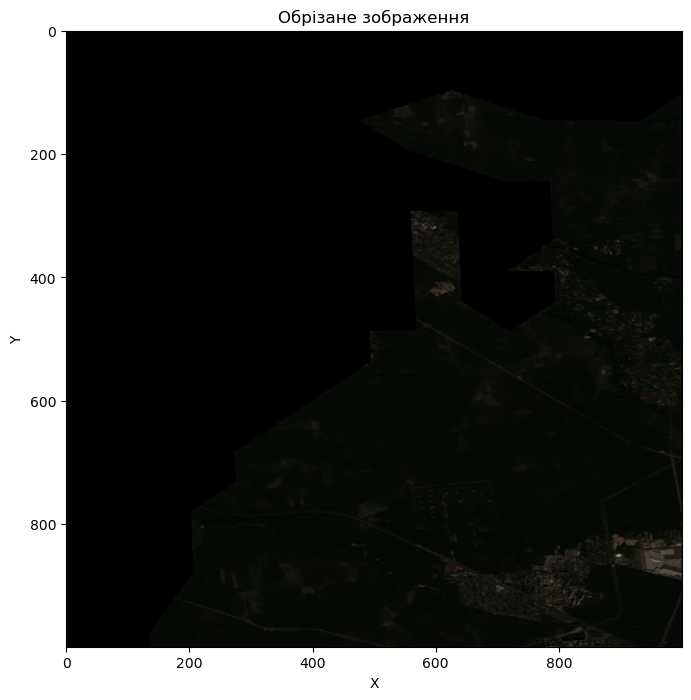

In [36]:

# шляхи
shapefile = "lab71/kyiv_regions.shp"
merged_output = "lab71/result/final_merged_4bands.tif"
clipped_output = "lab71/result/final_clipped.tif"

# перевірка існування шейпу
if not os.path.exists(shapefile):
    print("Шейп-файл не знайдено:", shapefile)
else:
    print("Шейп-файл знайдено")

    # перевірка CRS шейпу
    try:
        gdf = gpd.read_file(shapefile)
        print("CRS шейп-файлу:", gdf.crs)
    except Exception as e:
        print("⚠️ Не вдалося прочитати шейп-файл:", e)

# обрізання через gdalwarp + лог
cut_cmd = [
    "gdalwarp",
    "-cutline", shapefile,
    "-crop_to_cutline",
    "-dstnodata", "0",
    merged_output,
    clipped_output
]

result = subprocess.run(cut_cmd, capture_output=True, text=True)
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

# перевірка чи файл створено
if not os.path.exists(clipped_output):
    print("Обрізане зображення не створено:", clipped_output)
else:
    print("Обрізане зображення створено:", clipped_output)

    # візуалізація обрізаного
    try:
        with rasterio.open(clipped_output) as src:
            rgb = src.read([3, 2, 1])
            rgb_cropped = rgb[:, :1000, :1000]
            rgb_norm = np.clip(rgb_cropped.transpose(1, 2, 0) / 10000, 0, 1)

            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_norm)
            plt.title("Обрізане зображення")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()
    except Exception as e:
        print("Помилка при відкритті обрізаного зображення:", e)


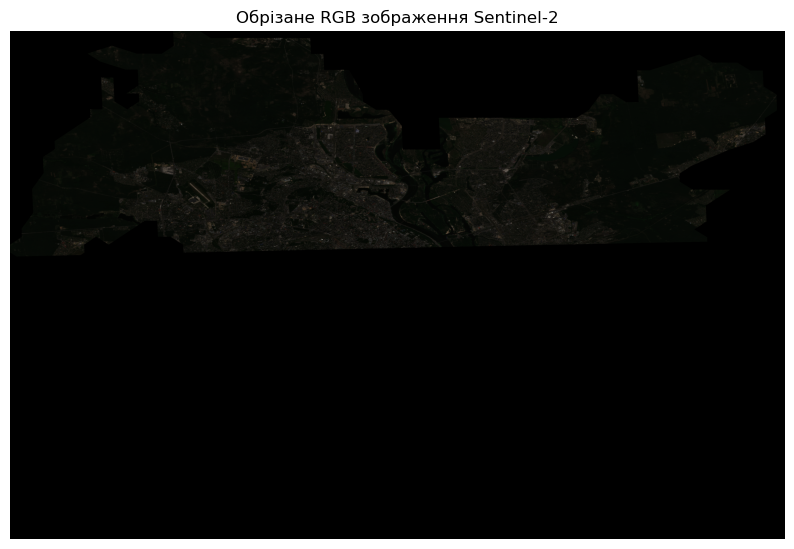

In [37]:
clipped = "lab71/result/final_clipped.tif"

try:
    with rasterio.open(clipped) as src:
        rgb = src.read([3, 2, 1])  # канали B04, B03, B02
        rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)

        plt.figure(figsize=(10, 10))
        plt.imshow(rgb_norm)
        plt.title("Обрізане RGB зображення Sentinel-2")
        plt.axis("off")
        plt.show()

except Exception as e:
    print(f"Не вдалося відкрити {clipped}: {e}")
